In [1]:
import matplotlib.pyplot as plt                 # For normal plotting
from mpl_toolkits.mplot3d import proj3d         # For 3D plotting
import numpy as np                              # For maths
from scipy import ndimage                       # For image rotations
from scipy import optimize                      # For function minimization
import astra                                    # For tomography framework
import copy                                     # For deep copying arrays

import RegTomoReconMulti as rtr                 # Modified version of Rob's CS code
import multi_axis                               # My custom functions

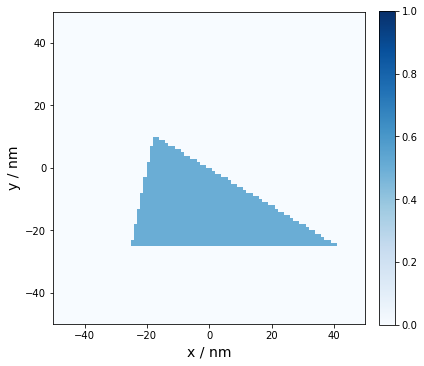

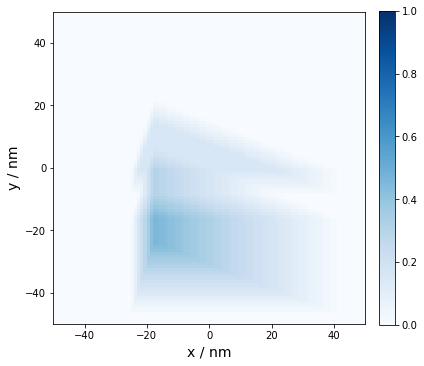

In [2]:
# Generate phantom
X,Y,Z,P = multi_axis.generate_tri_pris()

# View in 2D
multi_axis.plot_2d(X,Y,Z,P)

# Rotate 90 about +x and view again
Pr = multi_axis.rotate_bulk(P,50,0,0)
multi_axis.plot_2d(X,Y,Z,Pr)

In [137]:
def generate_angles(x_tilt = (-70,70,11), y_tilt = None, n_random = 0):
    """ Return a list of [ax,ay,az] lists, each corresponding to axial
    rotations applied to [0,0,1] to get a new projection direction.
    
    To include tilt series about x or y, 
    specify _tilt with (min_angle, max_angle, n_angles) in deg for
    a linear spacing of angles, set to None if not desired. 
    
    Add n_random tilt orientations with angle chosen between +-90, 
    or set to 0 for none."""
    
    angles = []
    ax,ay,az = 0,0,0
    
    # x series
    if x_tilt != None:
        for ax in np.linspace(x_tilt[0],x_tilt[1],x_tilt[2]):
            angles.append([ax,ay,az])
    
    # y series
    ax,ay,az = 0,0,0
    if y_tilt != None:
        for ay in np.linspace(y_tilt[0],y_tilt[1],y_tilt[2]):
            angles.append([ax,ay,az])
    
    # random series
    if n_random > 0:
        for i in range(n_random):
            as_rand = np.random.rand(3)*180 - 90
            angles.append(as_rand.tolist())
    
    return angles

def generate_proj_data(P,angles):
    """ Returns projection dataset given phantom P
    and 3D projection angles list.
    
    Output is normalised and reshaped such that the
    projection slice dimension is in the middle, so as
    to be compatible with astra."""
    P_projs = []
    
    for [ax,ay,az] in angles:
        P_rot = multi_axis.rotate_bulk(P,ax,ay,az)
        P_rot_proj =np.flipud(np.mean(P_rot,axis=2).T)
        P_projs.append(P_rot_proj)
        
    # Prepare projections for reconstruction
    raw_data = np.array(P_projs)
    raw_data = raw_data -  raw_data.min()
    raw_data = raw_data/raw_data.max()
    raw_data = np.transpose(raw_data,axes=[1,0,2]) # reshape so z is middle column
        
    return raw_data
      
def generate_vectors(angles):
    """ Converts list of 3D projection angles into
    list of astra-compatible projection vectors,
    with [r,d,u,v] vectors on each row. """
    vectors = []
    for [ax,ay,az] in angles:
        vector = multi_axis.get_astravec(ax,ay,az)
        vectors.append(vector)
    
    return vectors

def generate_reconstruction(raw_data,vectors, algorithm = 'SIRT3D_CUDA', niter=10, weight = 0.01,
                            balance = 1, steps = 'backtrack'):

    # Astra default algorithms
    if algorithm in ['SIRT3D_CUDA','FP3D_CUDA','BP3D_CUDA','CGLS3D_CUDA']:
        # Load data objects into astra C layer
        proj_geom = astra.create_proj_geom('parallel3d_vec',np.shape(raw_data)[0],np.shape(raw_data)[2],np.array(vectors))
        projections_id = astra.data3d.create('-sino', proj_geom, raw_data)
        vol_geom = astra.creators.create_vol_geom(np.shape(raw_data)[0], np.shape(raw_data)[0],
                                                  np.shape(raw_data)[2])
        reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)
        alg_cfg = astra.astra_dict(algorithm)
        alg_cfg['ProjectionDataId'] = projections_id
        alg_cfg['ReconstructionDataId'] = reconstruction_id
        algorithm_id = astra.algorithm.create(alg_cfg)

        astra.algorithm.run(algorithm_id,iterations=niter)
        recon = astra.data3d.get(reconstruction_id)
    
    # CS TV using RTR
    if algorithm == 'TV1':
        data = rtr.tomo_data(raw_data, np.array(vectors), degrees=True,
                    tilt_axis=0, stack_dim=1)

        vol_shape = (data.shape[0],data.shape[0],data.shape[2])
        projector = data.getOperator(vol_shape=vol_shape,
                                    backend='astra',GPU=True)
        alg = rtr.TV(vol_shape, order=1)
        
        recon = alg.run(data=data,op=projector, maxiter=niter, weight=weight,
                balance=balance, steps=steps,
                callback=None)
    
    return recon

def reorient_reconstruction(r):
    # Swap columns back to match orientation of phantom
    r = np.transpose(r,[2,1,0]) # Reverse column order
    r = r[:,::-1,:] # Reverse the y data
    r = r -  r.min() # normalise
    r = r/r.max()

    recon_vector = copy.deepcopy(r)
    
    return recon_vector


In [112]:
np.shape(raw_data)[2]

100

In [106]:
angles = generate_angles()
raw_data = generate_proj_data(P,angles)
vectors = generate_vectors(angles)

In [135]:
recon = generate_reconstruction(raw_data,vectors,algorithm='TV1')

TV1
Started reconstruction... Finished after 1 s
plasf


In [138]:
recon_vector = reorient_reconstruction(recon)

0.3079438945193888

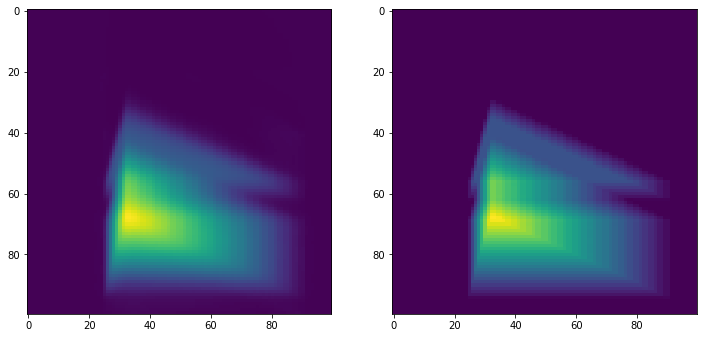

In [139]:
ax,ay,az = 40,0,0
a = multi_axis.rotate_bulk(recon_vector,ax,ay,az)

fig= plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(np.flipud(np.mean(a,axis=2).T))
ax2.imshow(np.flipud(np.mean(multi_axis.rotate_bulk(P,ax,ay,az),axis=2).T))

opt = optimize.minimize(phantom_error,1,args=(recon_vector,P))
opt.fun

In [3]:
# Create tilt series about x
ax,ay,az = 0,0,0

P_projs = []
vectors = []
thetas = []
for ay in np.linspace(-90,90,20):
    vector = multi_axis.get_astravec(ax,ay,az)
    #vector[0:3] = np.array(multi_axis.rotation_matrix(ax,ay,az)).dot([0,0,1])
    thetas.append(ax*np.pi/180)
    vectors.append(vector)
    P_rot = multi_axis.rotate_bulk(P,ax,ay,az)
    P_rot_proj =np.flipud(np.mean(P_rot,axis=2).T)
    P_projs.append(P_rot_proj)
    
raw_data = P_projs
np.shape(raw_data)

(20, 100, 100)

In [20]:
# Create tilt series about x and y
ax,ay,az = 0,0,0

P_projs = []
vectors = []
for ax in np.linspace(-70,70,10):
    vector = multi_axis.get_astravec(ax,ay,az)
    vectors.append(vector)
    P_rot = multi_axis.rotate_bulk(P,ax,ay,az)
    P_rot_proj =np.flipud(np.mean(P_rot,axis=2).T) # flipud .T was here before
    P_projs.append(P_rot_proj)

ax = 0
for ay in np.linspace(-70,70,10):
    vector = multi_axis.get_astravec(ax,ay,az)
    vectors.append(vector)
    P_rot = multi_axis.rotate_bulk(P,ax,ay,az)
    P_rot_proj =np.flipud(np.mean(P_rot,axis=2).T)
    P_projs.append(P_rot_proj)
    
raw_data = P_projs
np.shape(raw_data)

(20, 100, 100)

In [21]:
# Prepare projections for reconstruction
raw_data = np.array(raw_data)
raw_data = raw_data -  raw_data.min()
raw_data = raw_data/raw_data.max()
raw_data = np.transpose(raw_data,axes=[1,0,2]) # reshape so z is middle column
np.shape(raw_data)

(100, 20, 100)

0.0

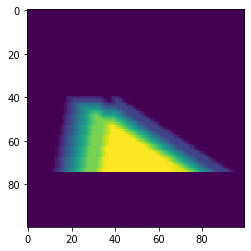

In [7]:
# This shouldn't need flipping/transposing because it is projection data
plt.imshow(raw_data[:,7,:])
thetas[9]*180/np.pi

In [107]:
# Load data objects into astra C layer
proj_geom = astra.create_proj_geom('parallel3d_vec',100,100,np.array(vectors))
projections_id = astra.data3d.create('-sino', proj_geom, raw_data)
vol_geom = astra.creators.create_vol_geom(100, 100,
                                          100)
reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)
alg_cfg = astra.astra_dict('SIRT3D_CUDA')
alg_cfg['ProjectionDataId'] = projections_id
alg_cfg['ReconstructionDataId'] = reconstruction_id
algorithm_id = astra.algorithm.create(alg_cfg)

In [108]:
# Run algorithm
astra.algorithm.run(algorithm_id,iterations=20)
reconstruction = astra.data3d.get(reconstruction_id)
np.shape(reconstruction)

(100, 100, 100)

This works if:
- P_rot is flipped and transposed
- The projection dataset is then transposed [1,0,2]
- r is just mrot.[0,0,1]
- ay becomes -ay in rotate bulk
- We then reverse column order and flip y

0.7848560666753508

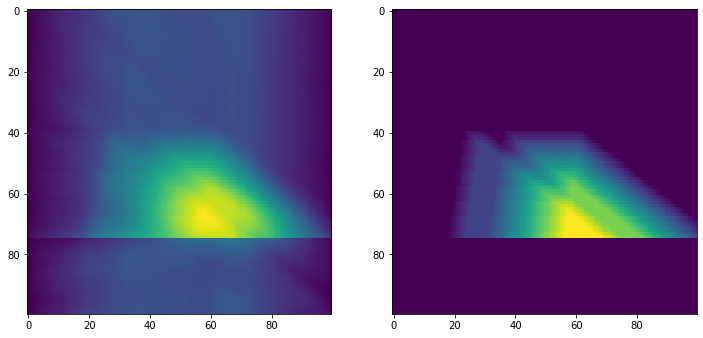

In [109]:
# This seems to work well for single axis datasets with raw data transpose [1,0,2]

# Swap columns back to match orientation of phantom
r = np.transpose(reconstruction,[2,1,0]) # Reverse column order
r = r[:,::-1,:] # Reverse the y data
r = r -  r.min() # normalise
r = r/r.max()

recon_vector = copy.deepcopy(r)

ax,ay,az = 0,40,0
a = multi_axis.rotate_bulk(recon_vector,ax,ay,az)
#multi_axis.plot_2d(X,Y,Z,a)

fig= plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(np.flipud(np.mean(a,axis=2).T))
ax2.imshow(np.flipud(np.mean(multi_axis.rotate_bulk(P,ax,ay,az),axis=2).T))

opt = optimize.minimize(phantom_error,1,args=(recon_vector,P))
opt.fun

In [22]:
# CS recon loading
import RegTomoReconMulti as rtr

data = rtr.tomo_data(raw_data, np.array(vectors), degrees=True,
                    tilt_axis=0, stack_dim=1)

vol_shape = (data.shape[0],100,data.shape[2])
projector = data.getOperator(vol_shape=vol_shape,
                            backend='astra',GPU=True)
alg = rtr.TV(vol_shape, order=1)

In [23]:
maxiter = 10#00
weight = 0.01
balance = 1
steps = 'backtrack'

recon = alg.run(data=data,op=projector, maxiter=maxiter, weight=weight,
                balance=balance, steps=steps,
                callback=None)#('primal','gap','violation','step'))[0]

if steps=='adaptive':
    print('Optimal balance was: ', (alg.s/alg.t)**.5)

Started reconstruction... Finished after 1 s


0.330968856654171

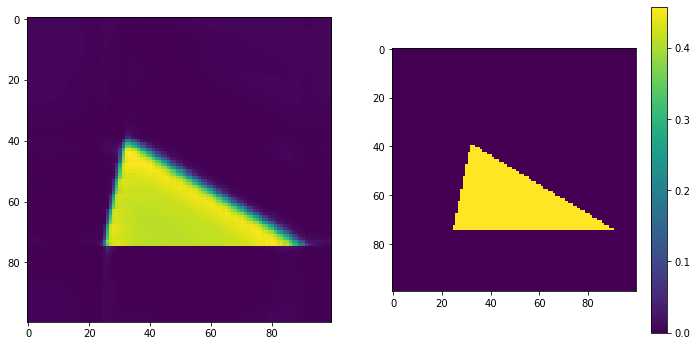

In [32]:
# This seems to work well for single axis datasets with raw data transpose [1,0,2]

# Swap columns back to match orientation of phantom
r = np.transpose(recon,[2,1,0]) # Reverse column order
r = r[:,::-1,:] # Reverse the y data
r = r -  r.min() # normalise
r = r/r.max()

recon_vector = copy.deepcopy(r)

ax,ay,az = 0,0,0
a = multi_axis.rotate_bulk(recon_vector,ax,ay,az)
#multi_axis.plot_2d(X,Y,Z,a)

fig= plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
im1 = ax1.imshow(np.flipud(np.mean(a,axis=2).T))
im2 = ax2.imshow(np.flipud(np.mean(multi_axis.rotate_bulk(P,ax,ay,az),axis=2).T))
plt.colorbar(im)
opt = optimize.minimize(phantom_error,1,args=(recon_vector,P))
opt.fun

In [12]:
def phantom_error(beta,recon,P):
    a = np.linalg.norm(recon*beta-P)
    b = np.linalg.norm(P)
    return a/b

In [37]:
opt = optimize.minimize(phantom_error,1,args=(recon_vector,P2))
opt.fun,opt.beta

NameError: name 'P2' is not defined

In [42]:
x = np.ones_like(P)*0
opt = optimize.minimize(phantom_error,1,args=(x,P))
opt.fun, opt.x[0]

(1.0, 1.0)

In [82]:
b = P -  P.min()
b = b/b.max()

In [90]:
np.max(recon_vector)

1.0

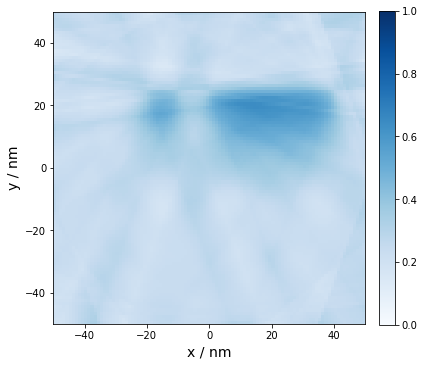

In [113]:
a = multi_axis.rotate_bulk(recon_vector,0,0,0)
multi_axis.plot_2d(X,Y,Z,a)

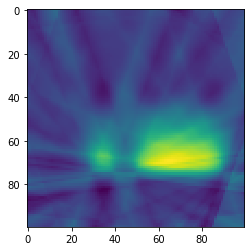

In [61]:
# Plot vector
plt.imshow(np.sum(recon_vector,axis=0))
#plt.colorbar()

a = multi_axis.rotate_bulk(recon_vector,0,0,0)
#multi_axis.plot_2d(X,Y,Z,a)
plt.imshow(np.sum(a,axis=2))
#plt.colorbar()

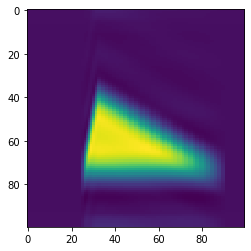

In [14]:
plt.imshow(np.mean(recon_normal,axis=0))

In [38]:
# Sum differences
np.sum(recon_vector-recon_normal)

-5.5531316e-05

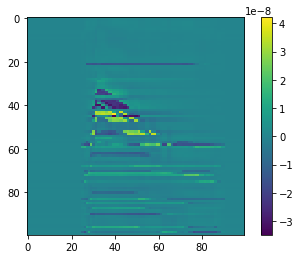

In [41]:
# Plot differences
a = recon_normal-recon_vector
plt.imshow(np.mean(a,axis=0))
plt.colorbar()